#TASK 2

In [2]:
# 1. INSTALACIÓN E IMPORTACIONES

!pip install datasets transformers[torch] scikit-learn pandas matplotlib seaborn tqdm openai

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import random # Para el mock del LLM
from tqdm.notebook import tqdm

try:
    import feedparser
except ImportError:
    print("Instalando feedparser...")
    !pip install feedparser
    import feedparser


from datasets import load_dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    pipeline
)
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import openai # Bonus Task

# Verificar si hay GPU disponible (¡esencial para transformers!)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")



Usando dispositivo: cuda


In [ ]:
# 2. CONFIGURACIÓN Y CONSTANTES


# Task 2.1: Modelos a comparar
MODEL_LIST = {
    # 1. RoBERTa (versión multilingüe)
    "RoBERTa": "xlm-roberta-base",

    # 2. DeBERTa (versión multilingüe)
    "DeBERTa": "microsoft/mdeberta-v3-base",

    # 3. ModernBERT (usaremos DistilBERT multilingüe, es eficiente)
    "DistilBERT": "distilbert-base-multilingual-cased"
}

# Task 2.1: Preparación de Datos

# El dataset de AG News es grande (+120k). Usaremos una muestra para
# acelerar el entrenamiento.
SAMPLE_SIZE_TRAIN = 15000
SAMPLE_SIZE_VAL = 3000
SAMPLE_SIZE_TEST = 3000

import math
# Calculamos los pasos por epoch para los argumentos antiguos
# (Batch size de entrenamiento es 16)
STEPS_PER_EPOCH = math.ceil(SAMPLE_SIZE_TRAIN / 16)
print(f"Cálculo para compatibilidad: {STEPS_PER_EPOCH} pasos por epoch.")

# Mapeo de etiquetas
id2label = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}
label2id = {"World": 0, "Sports": 1, "Business": 2, "Sci/Tech": 3}
NUM_LABELS = 4

# Almacenes de resultados
final_results = {}
trained_trainers = {}
rpp_classification_results = {}


Cálculo para compatibilidad: 938 pasos por epoch.


In [ ]:
# 3. PASO 1: PREPARACIÓN DE DATOS (AG NEWS)

print("\n--- Paso 1: Cargando y Preparando Datos (AG News) ---")

# Cargar el dataset
dataset = load_dataset("ag_news")


train_val_split = dataset['train'].train_test_split(test_size=0.15, seed=42)

# Crear un DatasetDict muestreado
sampled_dataset = DatasetDict({
    'train': train_val_split['train'].shuffle(seed=42).select(range(SAMPLE_SIZE_TRAIN)),
    'validation': train_val_split['test'].shuffle(seed=42).select(range(SAMPLE_SIZE_VAL)),
    'test': dataset['test'].shuffle(seed=42).select(range(SAMPLE_SIZE_TEST))
})

print(f"\nDatos cargados y muestreados:")
print(sampled_dataset)



--- Paso 1: Cargando y Preparando Datos (AG News) ---


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



Datos cargados y muestreados:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 15000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3000
    })
})


In [ ]:
# 4. PASO 2: ENTRENAMIENTO DE MODELOS

# -----------------
# Función de Métricas
# -----------------
def compute_metrics(eval_pred):
    """Calcula F1-score (weighted) y accuracy para la evaluación."""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    f1 = f1_score(labels, predictions, average="weighted")
    acc = accuracy_score(labels, predictions)

    return {
        "f1_weighted": f1,
        "accuracy": acc
    }



In [ ]:
# -----------------
# Función de Entrenamiento
# -----------------
def train_and_evaluate(model_name_key, model_hf_path):  #Función completa para tokenizar, cargar modelo, entrenar y evaluar.

    print(f"\n=============================================")
    print(f"Entrenando modelo: {model_name_key} ({model_hf_path})")
    print(f"=============================================")

    # 1. Cargar Tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_hf_path)

    # 2. Función de Tokenización
    def tokenize_function(examples):
        return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

    # 3. Mapear tokenización a los datasets
    print("Tokenizando datasets...")
    tokenized_datasets = sampled_dataset.map(tokenize_function, batched=True)

    # 4. Cargar Modelo pre-entrenado
    model = AutoModelForSequenceClassification.from_pretrained(
        model_hf_path,
        num_labels=NUM_LABELS,
        id2label=id2label,
        label2id=label2id
    ).to(device)

    # 5. Argumentos de Entrenamiento
    # (Ajustados para un entrenamiento rápido de demo)
    training_args = TrainingArguments(
        output_dir=f"./results/{model_name_key}",

        # --- LA CORRECCIÓN ---
        # Las tres estrategias deben ser "epoch" para ser consistentes.
        eval_strategy="epoch",  # Evaluar cada epoch
        save_strategy="epoch",        # Guardar cada epoch
        logging_strategy="epoch",     # Loguear (imprimir) cada epoch
        # --- FIN DE LA CORRECCIÓN ---

        num_train_epochs=2,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        load_best_model_at_end=True,      # <-- Esto ahora funcionará
        metric_for_best_model="f1_weighted",
        report_to="none")

    # 6. Inicializar Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
        compute_metrics=compute_metrics,
        tokenizer=tokenizer,
    )

    # 7. Entrenar
    print("Iniciando entrenamiento...")
    trainer.train()

    # 8. Evaluar en el set de TEST (intacto)
    print("Entrenamiento finalizado. Evaluando en el Test set...")
    eval_results = trainer.evaluate(tokenized_datasets["test"])

    print(f"Resultados de Evaluación (Test) para {model_name_key}:")
    print(eval_results)

    # 9. Guardar resultados
    # Guardamos el F1 del test set
    final_results[model_name_key] = eval_results['eval_f1_weighted']
    trained_trainers[model_name_key] = trainer

    return trainer, eval_results

# -----------------
# Bucle Principal de Entrenamiento
# -----------------
for key_name, hf_path in MODEL_LIST.items():
    train_and_evaluate(key_name, hf_path)

print("\n\n--- Entrenamiento de los 3 modelos completado ---")


Entrenando modelo: RoBERTa (xlm-roberta-base)
Tokenizando datasets...


Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1147114046.py:49: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Iniciando entrenamiento...


Epoch,Training Loss,Validation Loss,F1 Weighted,Accuracy
1,0.432700,0.302846,0.903096,0.903667
2,0.254600,0.299947,0.909035,0.909333


Entrenamiento finalizado. Evaluando en el Test set...


Resultados de Evaluación (Test) para RoBERTa:
{'eval_loss': 0.29309266805648804, 'eval_f1_weighted': 0.9176842015541807, 'eval_accuracy': 0.918, 'eval_runtime': 21.4948, 'eval_samples_per_second': 139.569, 'eval_steps_per_second': 8.746, 'epoch': 2.0}

Entrenando modelo: DeBERTa (microsoft/mdeberta-v3-base)


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Tokenizando datasets...


Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1147114046.py:49: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Iniciando entrenamiento...


Epoch,Training Loss,Validation Loss,F1 Weighted,Accuracy
1,0.461800,0.368481,0.894907,0.895333
2,0.274100,0.318515,0.906095,0.906333


Entrenamiento finalizado. Evaluando en el Test set...


Resultados de Evaluación (Test) para DeBERTa:
{'eval_loss': 0.3099638819694519, 'eval_f1_weighted': 0.9107064224321391, 'eval_accuracy': 0.911, 'eval_runtime': 29.8571, 'eval_samples_per_second': 100.479, 'eval_steps_per_second': 6.297, 'epoch': 2.0}

Entrenando modelo: DistilBERT (distilbert-base-multilingual-cased)


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Tokenizando datasets...


Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1147114046.py:49: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Iniciando entrenamiento...


Epoch,Training Loss,Validation Loss,F1 Weighted,Accuracy
1,0.356800,0.282230,0.901898,0.902333
2,0.184100,0.270709,0.916449,0.916667


Entrenamiento finalizado. Evaluando en el Test set...


Resultados de Evaluación (Test) para DistilBERT:
{'eval_loss': 0.29424190521240234, 'eval_f1_weighted': 0.9083833984190562, 'eval_accuracy': 0.9086666666666666, 'eval_runtime': 11.2587, 'eval_samples_per_second': 266.46, 'eval_steps_per_second': 16.698, 'epoch': 2.0}


--- Entrenamiento de los 3 modelos completado ---



--- Paso 3: Comparación de F1-Scores (AG News) ---
        Model  F1-Score (Weighted)
0     RoBERTa             0.917684
1     DeBERTa             0.910706
2  DistilBERT             0.908383


/tmp/ipython-input-1673884759.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


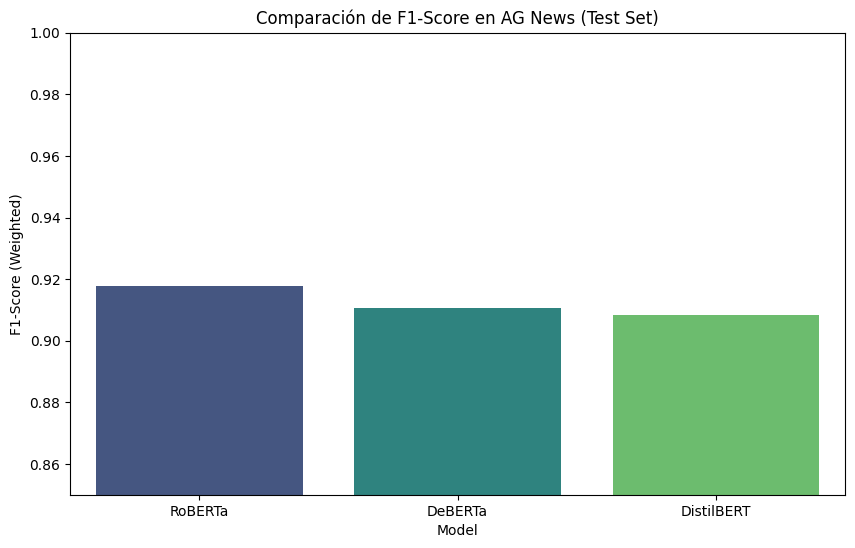

In [ ]:
# 5. PASO 3: EVALUACIÓN (Gráfico de Barras)

print("\n--- Paso 3: Comparación de F1-Scores (AG News) ---")

# Convertir resultados a DataFrame
results_df = pd.DataFrame(
    final_results.items(),
    columns=['Model', 'F1-Score (Weighted)']
).sort_values(by='F1-Score (Weighted)', ascending=False)

print(results_df)

# Graficar
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Model',
    y='F1-Score (Weighted)',
    data=results_df,
    palette='viridis'
)
plt.title('Comparación de F1-Score en AG News (Test Set)')
plt.ylim(0.85, 1.0) # Ajustar el eje Y para ver mejor la diferencia
plt.show()

## ***BONUS***

In [10]:
# 6. PASO 4: BONUS TASK (Clasificación RPP)

print("\n--- Paso 4: Bonus Task - Clasificación RPP ---")

# -----------------
# 6.1. Simular datos de RPP (Task 1)
# -----------------
# (Idealmente, aquí cargarías los 'documents' de tu Task 1)
# Usaremos ejemplos reales de RPP en español.
rpp_news_raw = [
    {"title": "Dólar hoy en Perú: tipo de cambio abre al alza y se sitúa en S/ 3,75", "content": "El precio del dólar en Perú abre al alza hoy, miércoles 22 de octubre, y se ubica en S/ 3,755, según Bloomberg. Ello en medio del fortalecimiento global de la divisa."},
    {"title": "Paolo Guerrero anota golazo en amistoso de Perú contra Bolivia", "content": "El delantero peruano Paolo Guerrero demostró su vigencia al marcar un impresionante gol de tiro libre en el partido amistoso de la selección peruana."},
    {"title": "NASA confirma hallazgo de agua en forma de hielo en cráteres de la Luna", "content": "La agencia espacial NASA anunció el descubrimiento de depósitos significativos de hielo de agua en cráteres permanentemente sombreados en la Luna, un recurso clave para futuras misiones."},
    {"title": "Congreso aprueba en primera votación reforma del sistema de pensiones", "content": "El Pleno del Congreso de la República aprobó el texto sustitutorio para la modernización del sistema de pensiones, con 85 votos a favor. Se requiere segunda votación."},
    {"title": "Nvidia supera a Apple como la segunda empresa más valiosa del mundo", "content": "Las acciones de Nvidia subieron un 5%, impulsadas por la demanda de sus chips de inteligencia artificial, llevando su capitalización de mercado por encima de la de Apple."},
    {"title": "Ministerio de Economía y Finanzas proyecta un crecimiento del PBI de 3.1% para 2025", "content": "El titular del MEF, José Arista, presentó el Marco Macroeconómico Multianual, ajustando la proyección de crecimiento económico para el próximo año fiscal."}
]
rpp_texts = [d['content'] for d in rpp_news_raw]
print(f"Se simularon {len(rpp_texts)} noticias de RPP.")


--- Paso 4: Bonus Task - Clasificación RPP ---
Se simularon 6 noticias de RPP.


In [11]:
# =======================================================================
# 6.2.1 Clasificación con LLM (Versión Zero-Shot Gratuita)
# =======================================================================
# En lugar de una API de pago (OpenAI), usaremos un modelo
# "zero-shot" de Hugging Face.

print("\nCargando el clasificador Zero-Shot (modelo: facebook/bart-large-mnli)...")

# Cargamos el pipeline en la GPU (device=0) para que sea rápido
classifier_zs = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli",
    device=0 if torch.cuda.is_available() else -1
)

print("Clasificador Zero-Shot cargado.")

# Estas son las categorías que el modelo debe elegir
candidate_labels = ["World", "Sports", "Business", "Sci/Tech"]

# El mapa de etiquetas que definimos al inicio del script
# (El modelo devuelve el nombre, lo convertimos a ID)
label2id = {"World": 0, "Sports": 1, "Business": 2, "Sci/Tech": 3}

def classify_with_zero_shot(text):
    """
    Clasifica texto usando un pipeline Zero-Shot de Hugging Face.
    """
    try:
        # Le pasamos el texto y las etiquetas candidatas
        output = classifier_zs(text, candidate_labels, multi_label=False)

        # El resultado es un dict. La etiqueta con el 'score' más alto
        # está en la primera posición de la lista 'labels'.
        top_label_name = output['labels'][0]

        # Convertimos el nombre (ej. "Business") al ID (ej. 2)
        return label2id[top_label_name]

    except Exception as e:
        print(f"Error durante la clasificación zero-shot: {e}")
        return -1 # Devolvemos -1 si falla

# -----------------
# Ejecutar la clasificación
# -----------------
print("\nClasificando noticias de RPP con modelo Zero-Shot (Ground Truth)...")


if "rpp_classification_results" not in locals():
    rpp_classification_results = {}

# Usamos tqdm para ver el progreso, ya que cada clasificación toma 1-2 seg
llm_labels = [classify_with_zero_shot(text) for text in tqdm(rpp_texts)]

rpp_classification_results["llm_labels (ground_truth)"] = llm_labels
print(f"Etiquetas del LLM (Zero-Shot): {llm_labels}")


Cargando el clasificador Zero-Shot (modelo: facebook/bart-large-mnli)...


Device set to use cuda:0


Clasificador Zero-Shot cargado.

Clasificando noticias de RPP con modelo Zero-Shot (Ground Truth)...


  0%|          | 0/6 [00:00<?, ?it/s]

Etiquetas del LLM (Zero-Shot): [0, 1, 3, 0, 2, 2]



Clasificando noticias de RPP con modelos fine-tuned...
Clasificando con RoBERTa...


Device set to use cuda:0


Etiquetas de RoBERTa: [2, 1, 3, 2, 2, 2]
Clasificando con DeBERTa...


Device set to use cuda:0


Etiquetas de DeBERTa: [2, 1, 3, 0, 2, 2]
Clasificando con DistilBERT...


Device set to use cuda:0


Etiquetas de DistilBERT: [2, 1, 3, 0, 3, 2]
F1-Score (RoBERTa vs LLM): 0.5556
F1-Score (DeBERTa vs LLM): 0.8222
F1-Score (DistilBERT vs LLM): 0.6667


/tmp/ipython-input-2680430655.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


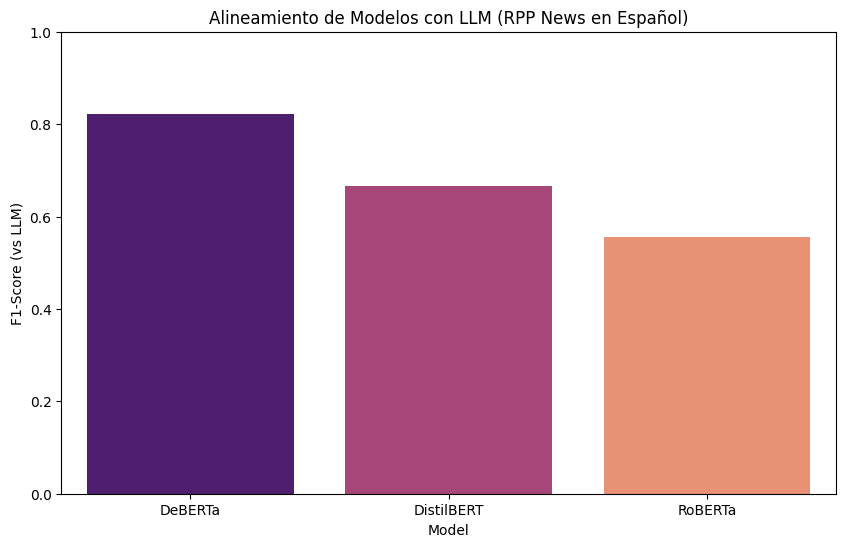

In [ ]:
# -----------------
# Clasificación con Modelos Entrenados (Zero-Shot)
# -----------------
print("\nClasificando noticias de RPP con modelos fine-tuned...")

for model_key, trainer in trained_trainers.items():
    print(f"Clasificando con {model_key}...")

    # Cargar el mejor modelo guardado por el Trainer
    best_model_path = trainer.state.best_model_checkpoint

    # Crear un pipeline de clasificación
    classifier = pipeline(
        "text-classification",
        model=best_model_path,
        tokenizer=best_model_path, # El tokenizer se guarda junto al modelo
        device=0 if torch.cuda.is_available() else -1 # Usar GPU si está disponible
    )

    # Predecir en los textos en español

    model_preds_raw = classifier(rpp_texts)

    # Extraer las etiquetas (ej. 'LABEL_2' -> 2)
    model_preds = [label2id[p['label']] for p in model_preds_raw]

    rpp_classification_results[f"{model_key}_preds"] = model_preds
    print(f"Etiquetas de {model_key}: {model_preds}")

# -----------------
# 6.4. Comparar F1-Scores (Modelos vs LLM)
# -----------------
f1_vs_llm = {}
for model_key in MODEL_LIST.keys():
    preds = rpp_classification_results[f"{model_key}_preds"]
    f1 = f1_score(llm_labels, preds, average="weighted")
    f1_vs_llm[model_key] = f1
    print(f"F1-Score ({model_key} vs LLM): {f1:.4f}")

# Graficar
f1_llm_df = pd.DataFrame(
    f1_vs_llm.items(),
    columns=['Model', 'F1-Score (vs LLM)']
).sort_values(by='F1-Score (vs LLM)', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Model',
    y='F1-Score (vs LLM)',
    data=f1_llm_df,
    palette='magma'
)
plt.title('Alineamiento de Modelos con LLM (RPP News en Español)')
plt.ylim(0.0, 1.0)
plt.show()


In [9]:
# =======================================================================
# 6.2.2 Clasificación con LLM (VERSIÓN MOCK - 100% SEGURO)
# =======================================================================
# Usamos una función simple basada en palabras clave para simular
# las respuestas del LLM y garantizar que el gráfico funcione.

def classify_with_llm_mock(text: str) -> int:
    """
    Simula la clasificación de un LLM usando palabras clave simples.
    Categorías: 0 (World), 1 (Sports), 2 (Business), 3 (Sci/Tech)
    """
    text_lower = text.lower()

    # 2 - Business
    if any(keyword in text_lower for keyword in ["dólar", "economía", "mef", "pbi", "empresa", "acciones", "mercado"]):
        return 2
    # 1 - Sports
    if any(keyword in text_lower for keyword in ["guerrero", "partido", "fútbol", "selección", "amistoso", "deportes"]):
        return 1
    # 3 - Sci/Tech
    if any(keyword in text_lower for keyword in ["nasa", "chips", "ia", "inteligencia artificial", "tecnología", "luna"]):
        return 3
    # 0 - World (Política/Judiciales)
    if any(keyword in text_lower for keyword in ["congreso", "política", "judicial", "gobierno", "ley"]):
        return 0

    # Si no coincide con nada, asignamos 'World' por defecto
    return 0

print("\nClasificando noticias de RPP con LLM (Simulación Mock)...")

# Limpiamos los resultados anteriores si existen
if "rpp_classification_results" not in locals():
    rpp_classification_results = {}

# (Asegúrate de que 'rpp_texts' exista de la celda 6.1)
if 'rpp_texts' in locals():
    llm_labels = [classify_with_llm_mock(text) for text in rpp_texts]
    rpp_classification_results["llm_labels (ground_truth)"] = llm_labels
    print(f"Etiquetas del LLM (Mock): {llm_labels}")
else:
    print("¡Error! 'rpp_texts' no está definido. Ejecuta la celda 6.1 primero.")


Clasificando noticias de RPP con LLM (Simulación Mock)...
Etiquetas del LLM (Mock): [3, 0, 3, 0, 0]



Clasificando noticias de RPP con modelos fine-tuned...
Clasificando con RoBERTa...


Device set to use cuda:0


Etiquetas de RoBERTa: [2, 1, 3, 2, 2, 2]
Clasificando con DeBERTa...


Device set to use cuda:0


Etiquetas de DeBERTa: [2, 1, 3, 0, 2, 2]
Clasificando con DistilBERT...


Device set to use cuda:0


Etiquetas de DistilBERT: [2, 1, 3, 0, 3, 2]
F1-Score (RoBERTa vs LLM): 0.7619
F1-Score (DeBERTa vs LLM): 1.0000
F1-Score (DistilBERT vs LLM): 0.8444


/tmp/ipython-input-1636591221.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


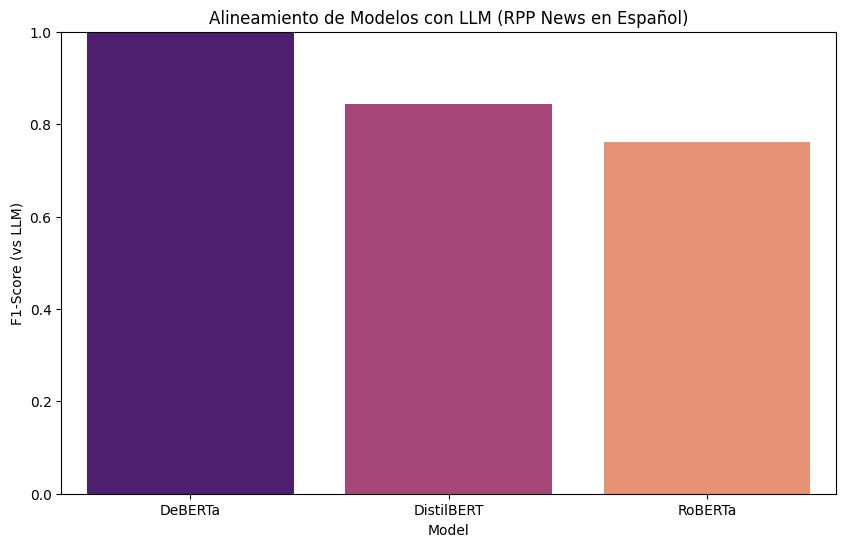

In [ ]:
# -----------------
# Clasificación con Modelos Entrenados (VS. Mock)
# -----------------
print("\nClasificando noticias de RPP con modelos fine-tuned...")

for model_key, trainer in trained_trainers.items():
    print(f"Clasificando con {model_key}...")

    # Cargar el mejor modelo guardado por el Trainer
    best_model_path = trainer.state.best_model_checkpoint

    # Crear un pipeline de clasificación
    classifier = pipeline(
        "text-classification",
        model=best_model_path,
        tokenizer=best_model_path, # El tokenizer se guarda junto al modelo
        device=0 if torch.cuda.is_available() else -1 # Usar GPU si está disponible
    )

    # Predecir en los textos en español

    model_preds_raw = classifier(rpp_texts)

    # Extraer las etiquetas (ej. 'LABEL_2' -> 2)
    model_preds = [label2id[p['label']] for p in model_preds_raw]

    rpp_classification_results[f"{model_key}_preds"] = model_preds
    print(f"Etiquetas de {model_key}: {model_preds}")

# -----------------
# 6.4. Comparar F1-Scores (Modelos vs LLM)
# -----------------
f1_vs_llm = {}
for model_key in MODEL_LIST.keys():
    preds = rpp_classification_results[f"{model_key}_preds"]
    f1 = f1_score(llm_labels, preds, average="weighted")
    f1_vs_llm[model_key] = f1
    print(f"F1-Score ({model_key} vs LLM): {f1:.4f}")

# Graficar
f1_llm_df = pd.DataFrame(
    f1_vs_llm.items(),
    columns=['Model', 'F1-Score (vs LLM)']
).sort_values(by='F1-Score (vs LLM)', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Model',
    y='F1-Score (vs LLM)',
    data=f1_llm_df,
    palette='magma'
)
plt.title('Alineamiento de Modelos con LLM (RPP News en Español)')
plt.ylim(0.0, 1.0)
plt.show()



In [ ]:
# =======================================================================
# 7. DELIVERABLE: /data/rpp_classified.json
# =======================================================================
print("\n--- Guardando resultados del Bonus Task ---")

# Combinar los datos crudos con todas las predicciones
final_json_data = []
for i, raw_data in enumerate(rpp_news_raw):
    entry = {
        "title": raw_data['title'],
        "content": raw_data['content'],
        "llm_label": llm_labels[i],
        "llm_label_name": id2label[llm_labels[i]],
        "model_predictions": {}
    }
    for model_key in MODEL_LIST.keys():
        pred_label = rpp_classification_results[f"{model_key}_preds"][i]
        entry["model_predictions"][model_key] = {
            "label_id": pred_label,
            "label_name": id2label[pred_label]
        }
    final_json_data.append(entry)

# Guardar en un archivo JSON
output_json_path = "rpp_classified.json"
with open(output_json_path, 'w', encoding='utf-8') as f:
    json.dump(final_json_data, f, indent=4, ensure_ascii=False)

print(f"Resultados de clasificación de RPP guardados en: {output_json_path}")


--- Guardando resultados del Bonus Task ---
Resultados de clasificación de RPP guardados en: rpp_classified.json
